In [2]:
import tensorflow as tf
import numpy as np
import os
import networkx as nx
import keras
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
# ! pip install networkx=2.3
! pip install spektral
from spektral.layers import GCNConv
!pip install torch-geometric
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

!mkdir data
!curl https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz -o data/cora.tgz
!tar -xzf ./data/cora.tgz -C ./data/
!rm ./data/cora.tgz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 5.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 15.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910476 sha256=38edd50263a92ebec3c3ee9f2c3c061e2ddfa172e3dccddcd29b3cfcb6a95401
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  164k  100  164k    0     0   96

In [3]:
all_data = []
all_edges = []

for root,dirs,files in os.walk('./data/cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())

all_data = shuffle(all_data,random_state= 42)

In [4]:
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])

X = np.array(X,dtype=int)
N = X.shape[0] 
F = X.shape[1]

print('X shape: ', X.shape)


#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)

X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {'Theory', 'Case_Based', 'Genetic_Algorithms', 'Rule_Learning', 'Reinforcement_Learning', 'Neural_Networks', 'Probabilistic_Methods'}

Number of classes:  7


In [5]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)


A = nx.adjacency_matrix(G)
print('Number of nodes', len(G.nodes))
print('Number of edges', len(G.edges))

#use gcc if you want. 


Number of nodes 2708
Number of edges 5278


In [6]:
#get 20 train instances per class
#remaining instances are in test set test  

# Split data into train/validation/test
train_size_per_class = 20
num_nodes_per_class = train_size_per_class * num_classes

train_mask = np.zeros(N, dtype=bool)
train_mask[np.random.choice(N, 20, replace=False)] = True
val_mask = np.zeros(N, dtype=bool)
val_mask[np.random.choice(N, 500, replace=False)] = True
test_mask = np.zeros(N, dtype=bool)
test_mask[~train_mask & ~val_mask] = True
# convert labels to integer array
labels = np.array(labels)
for c in range(num_classes):
    nodes_of_class = [i for i in range(len(labels)) if labels[i] == f'{c}']
    np.random.shuffle(nodes_of_class)
    train_mask[nodes_of_class[:train_size_per_class]] = True
    val_mask[nodes_of_class[train_size_per_class:num_nodes_per_class]] = True
    test_mask[nodes_of_class[num_nodes_per_class:]] = True

X_train, X_val, X_test = X[train_mask], X[val_mask], X[test_mask]
Y_train, Y_val, Y_test = labels[train_mask], labels[val_mask], labels[test_mask]
A_train = A[train_mask, :][:, train_mask]
A_test = A[test_mask, :][:, train_mask]
A_val = A[val_mask, :][:, train_mask]


In [8]:
from sklearn.preprocessing import LabelEncoder

# create LabelEncoder object
le = LabelEncoder()

# fit LabelEncoder on all labels
le.fit(labels)

# encode all labels
encoded_labels = le.transform(labels)
labels = le.fit_transform(labels)
labels = to_categorical(labels)
classes = le.classes_


In [13]:
# Parameters
#channels, dropout_prob, learning rate, epochs, etc         
channels = 16
dropout_prob = 0.5
lr = 0.01
num_epoch = 50
decay = 5e-4
# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)
A = GCNConv.preprocess(A).astype('f4')

#DEFINE YOUR MODEL HERE
dropout_1 = Dropout(dropout_prob)(X_in)
gcn_conv_1 = GCNConv(channels, activation='relu')([dropout_1, fltr_in])

dropout_2 = Dropout(dropout_prob)(gcn_conv_1)
graph_conv_2 = GCNConv(num_classes, activation='softmax')([dropout_2, fltr_in])


# Build model

model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
#model = GCN().to(device)

optimizer = Adam(learning_rate = lr, weight_decay = decay)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', weighted_metrics=['acc'])
model.summary()
## Reference: https://github.com/danielegrattarola/spektral/blob/88c715226555a87fc6251428d39d3d6463486307/tests/benchmarks/citation/citation.py#L130

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1433)]       0           []                               
                                                                                                  
 dropout_2 (Dropout)            (None, 1433)         0           ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 2708)]       0           []                               
                                                                                                  
 gcn_conv_2 (GCNConv)           (None, 16)           22944       ['dropout_2[0][0]',              
                                                                  'input_4[0][0]']          

In [14]:
# Train model

validation_data = ([X_val, A_val], Y_val)
model.fit(x = [X_train, A_train], y = Y_train,
          epochs=num_epoch,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          )


Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 0.1023 - acc: 0.0857 - val_loss: 0.3557 - val_acc: 0.2460
Epoch 2/50
1/1 [==============================] - 0s 91ms/step - loss: 0.0968 - acc: 0.2571 - val_loss: 0.3512 - val_acc: 0.3400
Epoch 3/50
1/1 [==============================] - 0s 91ms/step - loss: 0.0945 - acc: 0.3357 - val_loss: 0.3454 - val_acc: 0.3860
Epoch 4/50
1/1 [==============================] - 0s 100ms/step - loss: 0.0905 - acc: 0.5000 - val_loss: 0.3383 - val_acc: 0.4300
Epoch 5/50
1/1 [==============================] - 0s 89ms/step - loss: 0.0858 - acc: 0.5071 - val_loss: 0.3300 - val_acc: 0.4560
Epoch 6/50
1/1 [==============================] - 0s 89ms/step - loss: 0.0819 - acc: 0.5571 - val_loss: 0.3208 - val_acc: 0.4980
Epoch 7/50
1/1 [==============================] - 0s 93ms/step - loss: 0.0753 - acc: 0.6214 - val_loss: 0.3105 - val_acc: 0.5180
Epoch 8/50
1/1 [==============================] - 0s 88ms/step - loss: 0.0714 - acc: 0.6571 - val_

In [19]:
# Evaluate model

y_pred = model.predict([X_test, A_test], Y_testbatch_size=N)


report = classification_report(np.argmax(Y_test,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

1/1 [==============================] - 0s 48ms/step
GCN Classification Report: 
                         precision    recall  f1-score   support

Reinforcement_Learning       0.72      0.70      0.71       223
            Case_Based       0.82      0.76      0.79       319
    Genetic_Algorithms       0.87      0.54      0.67       618
         Rule_Learning       0.65      0.83      0.73       332
 Probabilistic_Methods       0.64      0.75      0.69       173
       Neural_Networks       0.54      0.79      0.64       136
                Theory       0.57      0.73      0.64       267

              accuracy                           0.70      2068
             macro avg       0.69      0.73      0.70      2068
          weighted avg       0.73      0.70      0.70      2068



1/1 [==============================] - 0s 193ms/step


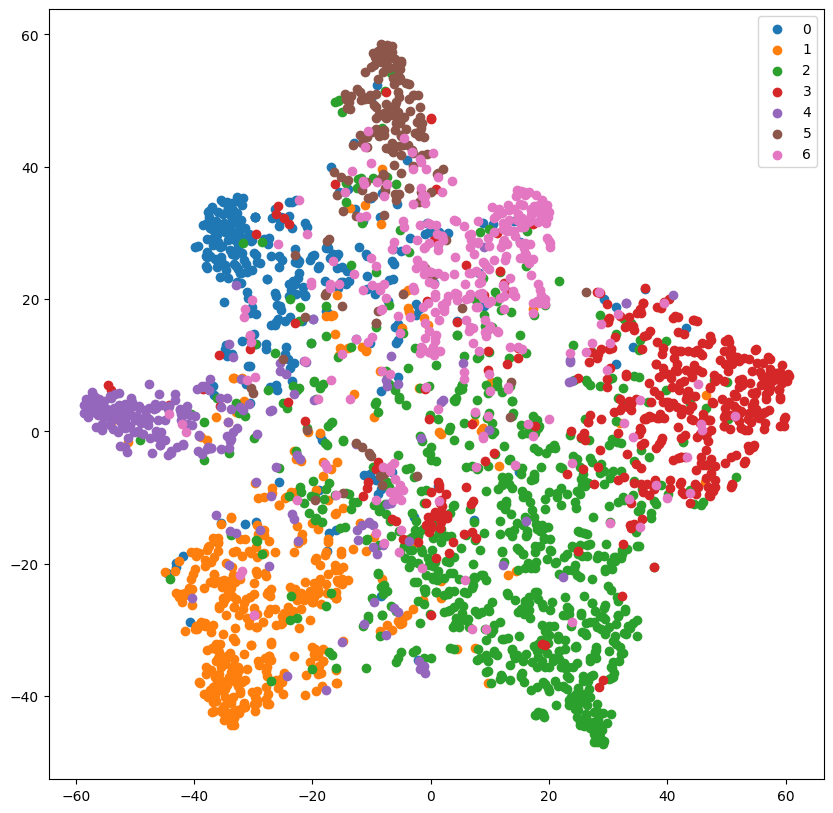

In [20]:

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)


x_tsne = TSNE(n_components=2).fit_transform(activations[3]) 

def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels,x_tsne)